In [148]:
import matplotlib.pyplot as plt # our plotting buddy
import numpy as np # the fabulous NumPy package
import scipy
import math
from mpl_toolkits.basemap import Basemap
import coeffs as cf

%matplotlib inline 


In [149]:
def magnetic_field(gsh,hsh,lmax,r,dlon=1,dlat=1):
    a=6371.2
    pi            = math.pi
    lats          = np.arange(-89,91,dlat)
    lons          = np.arange(-180,181,dlon)
    lons2d,lats2d = np.meshgrid(lons,lats)
    phi           = lons2d
    cost2d        = np.cos((90-lats2d)*pi/180)
    i             = 0
    br            = np.zeros((cost2d.shape))
    bphi          = np.zeros((cost2d.shape))
    btheta        = np.zeros((cost2d.shape))
    for l in np.arange(1,lmax+1,1):
        for m in np.arange(0,l+1,1):
            g=gsh[i]
            h=hsh[i]
            #calculate schmidt
            if m  == 0:
                schmidt = 1.0
            else:
                schmidt = ((-1.0)**m)*np.sqrt(2.0*math.factorial(l-m)/math.factorial(l+m))
            lagendre     = scipy.special.lpmv(m, l, cost2d)
            lagendre_    = scipy.special.lpmv(m, l-1, cost2d)
            div_lagendre = (l*cost2d*lagendre-(l+m)*lagendre_)/np.sqrt(1-cost2d**2)
            br           = br     + schmidt*(float(l)+1.0)*((a/r)**(l+2))*lagendre*(g*np.cos(float(m)*phi*pi/180.0)+h*np.sin(float(m)*phi*pi/180.0))
            bphi         = bphi   + schmidt*(m/np.sin((90-lats2d)*pi/180))*((a/r)**(l+2))*lagendre*(-g*np.sin(float(m)*phi*pi/180.0)+h*np.cos(float(m)*phi*pi/180.0))
            btheta       = btheta + schmidt*((a/r)**(l+2))*(div_lagendre)*(g*np.cos(float(m)*phi*pi/180.0)+h*np.sin(float(m)*phi*pi/180.0))
            i+=1
    return br,bphi,btheta,lons2d,lats2d

In [150]:
def unpack(gh):
    data = []
    k, l = 0, 1
    while k + 1 < len(gh):
        for m in range(l + 1):
            if m == 0:
                data.append([l, m, gh[k], 0])
                k += 1
            else:
                data.append([l, m, gh[k], gh[k + 1]])
                k += 2
        l += 1
    return data

In [151]:
def COV_OBS_SH(lmax,snapshot,r):
    time, coeffs = cf.get_covobs2()
    time =np.asarray(time)
    coeffs = np.array(coeffs)
    output_temp = open("temp.dat","w+")
    coeffs_snap = coeffs[time == snapshots[i]] 
    # unpack them into the form that lowes likes
    data=unpack(coeffs_snap[0])
    data=np.array(data)
    ysize,xsize=data.shape
    l_count=0
    for ll in range(0,lmax+1,1):
        l_count=l_count + (ll+1)
       
    for ii in range(0,l_count-1,1):
        output_temp.write( "%d %d %f %f\n" %(data[ii][0],data[ii][1],data[ii][2],data[ii][3]))
    output_temp.close()
        
    ls,ms,gs,hs= np.loadtxt("temp.dat").T
    r=+3485.0
    return ls,ms,gs,hs

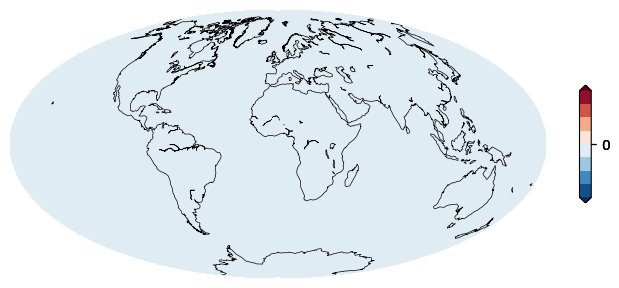

In [162]:
#SYNTHETIC
#Creating a spherical harmonics description
lmax=3 #\ell_{max}
l   = [1.00,1.00,2.00,2.00,2.00,3.00,3.00,3.00,3.00]#l
m   = [0.00,1.00,0.00,1.00,2.00,0.00,1.00,2.00,3.00]#m
glm = [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00]#glm
hlm = [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00]#hlm
r   = 3485.0 #radial distance (depth)

#Calculating the field
Br,Bphi,Btheta,lons,lats=magnetic_field(glm,hlm,lmax,r,dlon=2,dlat=2)

#ploting the field
plt.figure(figsize=(7,5))


lon2, lat2 = lons,lats
map = Basemap(projection='hammer',lon_0=0,lat_0=45)
x,y=map(lon2,lat2)
value = np.max(np.absolute(Br))
w=np.linspace(-value,value,59)
w_ticks=np.linspace(-value,value,3)

ax=plt.subplot(1,1,1)
if ((np.sum(glm)==0) & (np.sum(hlm)==0)):
    cs=ax.contourf(x,y,Br,cmap='RdBu_r',extend='both')
else:
    cs=ax.contourf(x,y,Br,w,cmap='RdBu_r',extend='both')

map.drawmapboundary(color='none',ax=ax)
map.drawcoastlines(color='k',linewidth=0.5)

#COLORBAR
cbar_ax = fig.add_axes([1.00, 0.35, 0.02, 0.25])
cl=fig.colorbar(cs, shrink=0.25, format='%d',ticks=w_ticks, aspect=10,orientation='vertical')
cl.ax.tick_params(labelsize=10)


#ploting the magnetic equator

plt.tight_layout()
plt.show()

In [157]:
#REAL
#For the COV-OBS.x2 (Huder et al., 2020) from 1840 until 2020 with timestep = 2 yr
snapshot=[2020]
lmax=5
r=+3485.0 

#This function prepare the Spherical Harmonics of the COV-OBS.x2 model
l,m,glm,hlm = COV_OBS_SH(lmax,snapshot,r) #for a maximum truncation(lmax), specific time (snapshot) and depth (r) 
#Calculating the field
Br,Bphi,Btheta,lons,lats=magnetic_field(glm,hlm,lmax,r,dlon=2,dlat=2)

    


In [156]:
#SPECTRAL
print(l)
print(m)
print(glm)
print(hlm)

[ 1.  1.  2.  2.  2.  3.  3.  3.  3.  4.  4.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  6.  6.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.]
[ 0.  1.  0.  1.  2.  0.  1.  2.  3.  0.  1.  2.  3.  4.  0.  1.  2.  3.
  4.  5.  0.  1.  2.  3.  4.  5.  6.  0.  1.  2.  3.  4.  5.  6.  7.  0.
  1.  2.  3.  4.  5.  6.  7.  8.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.
  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  0.  1.  2.  3.  4.  5.  6.
  7.  8.  9. 10. 11.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.
  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.  0.  1.  2.  3.
  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[-2.94071053e+04 -1.45087733e+03

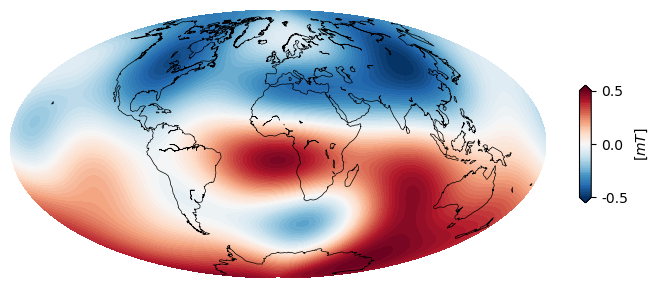

In [147]:
#changing units
Br_=Br*0.000001
#ploting the field
plt.figure(figsize=(7,5))


lon2, lat2 = lons,lats
map = Basemap(projection='hammer',lon_0=0,lat_0=45)
x,y=map(lon2,lat2)
value = np.max(np.absolute(Br_))
w=np.linspace(-value,value,59)
w_ticks=np.linspace(-value,value,3)

ax=plt.subplot(1,1,1)
cs=ax.contourf(x,y,Br_,w,cmap='RdBu_r',extend='both')

map.drawmapboundary(color='none',ax=ax)
map.drawcoastlines(color='k',linewidth=0.5)

#COLORBAR
cbar_ax = fig.add_axes([1.00, 0.35, 0.02, 0.25])
cl=fig.colorbar(cs, shrink=0.25, format='%.1f',ticks=w_ticks, aspect=10,orientation='vertical')
cl.set_label(r'[$m T$]')
cl.ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

## 